In [1]:
%matplotlib inline
import os
seed = 50
os.environ['PYTHONHASHSEED']=str(seed)
import scipy.io
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
# from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from hopls import matricize, qsquared, HOPLS
from skimage.metrics import normalized_root_mse
import random
from qpfs import *
from Autoencoder import *
from utils import *
from hankelization import * 
random_seed = 5
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
!CUBLAS_WORKSPACE_CONFIG=:16:8#:4096:8
#device='cuda:0'
device='cpu'

# Neurotycho food-tracking dataset, 32 channels

The monkey was tracking food rewards with the hand contralateral to the implant side. ECoG data and motion data were recorded simultaneously during the task (details in the reference). There was no eye tracking. ECoG and motion data were sampled at 1KHz and 120Hz, respectively, with time stamps synchronized. ECoG data consists of $32-$ time series (channels). The original signals are converted into a space time representation using a wavelet transform with Morlet wavelet. So, $X \in \mathbb{R}^{T \times 32 \times 27}$, where 27 - number of frequencies. $Y \in \mathbb{R}^{T \times 3}$ - coordinates of hand position.

<img src="pictures/2023-04-14_03-18-41.png" alt="Drawing" style="width: 300px;"/>

<img src="pictures/2023-04-14_03-19-11.png" alt="Drawing" style="width: 300px;"/>

In [2]:
X_test_n = np.transpose(scipy.io.loadmat('ECoG_X_test.mat')['X_hold_out'], (0,2,1))[1500:2250]
Y_test_n = scipy.io.loadmat('ECoG_Y_test.mat')['Y_hold_out'][1500:2250]
X_train_n = np.transpose(scipy.io.loadmat('ECoG_X_train.mat')['X_train'], (0,2,1))[:1500]
Y_train_n = scipy.io.loadmat('ECoG_Y_train.mat')['Y_train'][:1500]

X_test_n = (X_test_n - X_test_n.mean()) / X_test_n.std() 
Y_test_n = (Y_test_n - Y_test_n.mean()) / Y_test_n.std()
X_train_n = (X_train_n - X_train_n.mean()) / X_train_n.std()
Y_train_n = (Y_train_n - Y_train_n.mean()) / Y_train_n.std()

print('X train:', X_train_n.shape)
print('Y train:', Y_train_n.shape)
print('X test:', X_test_n.shape)
print('Y test:', Y_test_n.shape)

X_test = torch.from_numpy(X_test_n).float().to(device)
Y_test = torch.from_numpy(Y_test_n).float().to(device)
X_train = torch.from_numpy(X_train_n).float().to(device) 
Y_train = torch.from_numpy(Y_train_n).float().to(device)

X train: (1500, 27, 32)
Y train: (1500, 3)
X test: (750, 27, 32)
Y test: (750, 3)


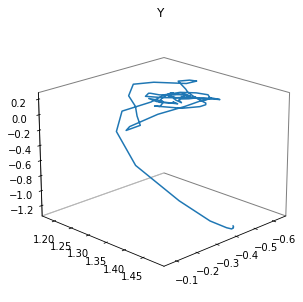

In [3]:
plot_y3D(Y_train_n)

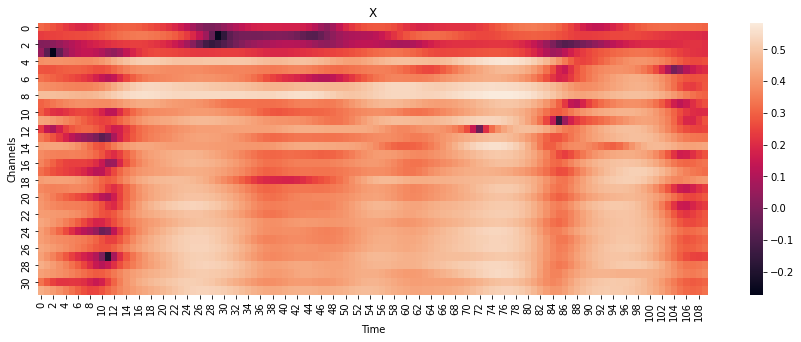

In [4]:
plot_x(X_train_n)

## Without hankelization
### HOPLS

In [5]:
MSE_test = dict(np.load('experiments/ECoG32_wt_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,3), Km = 1, R = 29 nRMSE = 1.6988894675002182


### MPCA

In [3]:
U_x = scipy.io.loadmat('MPCA/32_X.mat')['ans']
MSE_mpca = rmse_mpca(X_train_n, Y_train_n, X_test_n, Y_test_n, U_x)

8it [12:25, 93.16s/it] 


In [5]:
U_x = scipy.io.loadmat('MPCA/32_X.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 8]


In [4]:
print('Rank of weight tensor is', min(MSE_mpca, key=MSE_mpca.get), 'nRMSE =', MSE_mpca[min(MSE_mpca, key=MSE_mpca.get)])

Rank of weight tensor is (1, 2) nRMSE = 1.7642609425051774


### Autoencoder

In [7]:
MSE_test = dict(np.load('experiments/ECoG32_wt.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is 2,7 nRMSE = 1.0001555063858667


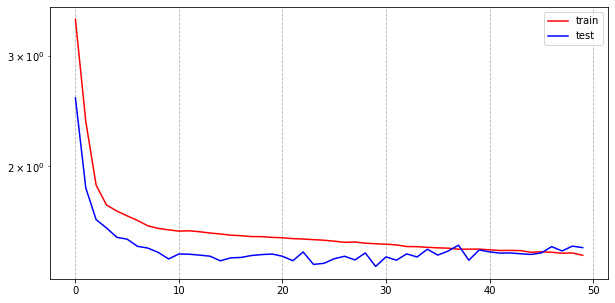

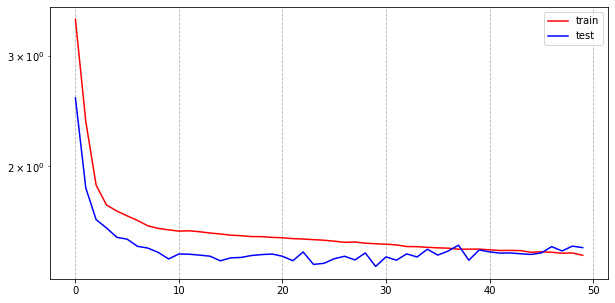

In [6]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 50
step_size = 100

fr, ch, y_sh = X_test_n.shape[1], X_test_n.shape[2], Y_test_n.shape[1]
ks = [fr,32,16,8,2]
model = AutoEncoder_tensor(3, [ks], [ch,7], y_sh, indexing=False).to(device)
model = train(model, X_train, Y_train, X_test, Y_test, lr, step_size, batch_size, epochs, loss_fn, True);

X_train_lower = model.encode(X_train).cpu().detach().numpy()
X_test_lower = model.encode(X_test).cpu().detach().numpy()

RMSE_dict = {}
for rank1 in range(1,X_train_lower.shape[1]+1,1):   
    for rank2 in range(1,X_train_lower.shape[2]+1,1):
        try:
            RMSE_dict[f'{rank1},{rank2}'] = tensor_regression(X_train_lower, Y_train_n, X_test_lower, Y_test_n, [rank1,rank2])
        except:
            continue

In [7]:
print('nRMSE =', RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

nRMSE = 1.075410982143173


## With hankelization along time dim

In [14]:
data, H_t = tensorization(X_train_n, Y_train_n, X_test_n, Y_test_n, [[10],[10]], [[0],[0]])
X_tr_ht_n, Y_tr_ht_n, X_te_ht_n, Y_te_ht_n = data

print('X train:', X_tr_ht_n.shape)
print('Y train:', Y_tr_ht_n.shape)
print('X test:', X_te_ht_n.shape)
print('Y test:', Y_te_ht_n.shape)

X_test = torch.from_numpy(X_te_ht_n).float().to(device)
Y_test = torch.from_numpy(Y_te_ht_n).float().to(device)
X_train = torch.from_numpy(X_tr_ht_n).float().to(device) 
Y_train = torch.from_numpy(Y_tr_ht_n).float().to(device) 

X train: (1491, 10, 27, 32)
Y train: (1491, 10, 3)
X test: (741, 10, 27, 32)
Y test: (741, 10, 3)


### HOPLS

In [6]:
MSE_test = dict(np.load('experiments/ECoG32_ht_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (3,1,1), Km = (1,1), R = 20 nRMSE = 1.146083560542331


### MPCA

In [9]:
U_x = scipy.io.loadmat('MPCA/32_X_ht.mat')['ans']
U_y = scipy.io.loadmat('MPCA/32_Y_ht.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [10, 1, 8]
Y [8, 3]


In [13]:
MSE_test = dict(np.load('experiments/ECoG32_ht_ht_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (9, 1, 5) nRMSE = 1.982342863404438


### Autoencoder

In [9]:
MSE_test = dict(np.load('experiments/ECoG32_ht.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get))

Size of core tensor is 1,1,7 nRMSE = 1.1356141845490086


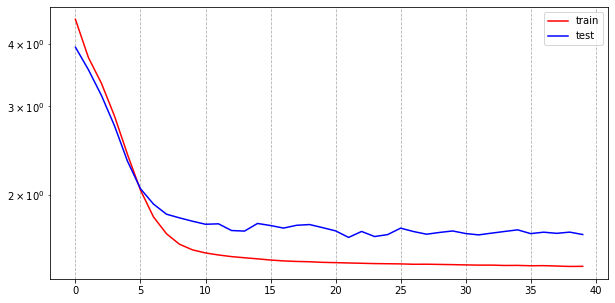

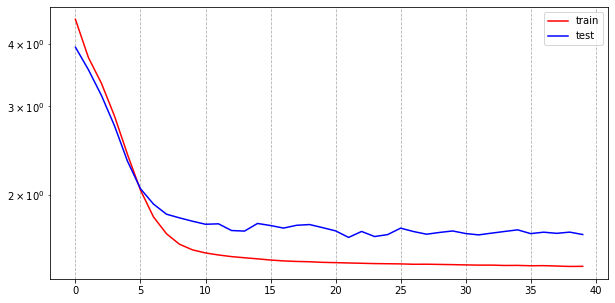

In [15]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 40
step_size = 100

fr, ch, y_sh = X_test_n.shape[1], X_test_n.shape[2], Y_test_n.shape[1]

ks1 = [fr,32,16,8,1]
ks2 = [ch,16,8,7]

model = AutoEncoder_tensor(4, [ks1, ks2], [10,1], y_sh*10, indexing=True).to(device)
model = train(model, X_train, Y_train, X_test, Y_test, lr, step_size, batch_size, epochs, loss_fn,True);

torch.cuda.empty_cache()
X_train_lower = model.encode(X_train).cpu().detach().numpy()
X_test_lower = model.encode(X_test).cpu().detach().numpy()

RMSE_dict = {}

for rank1 in range(1,X_train_lower.shape[1]+1,1):   
    for rank2 in range(1,X_train_lower.shape[2]+1,1):
        for rank3 in range(1,X_train_lower.shape[3]+1,1):
                RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_ht_n, X_test_lower, Y_te_ht_n, [rank1,rank2,rank3], H_t[-1])


In [16]:
print('nRMSE =', RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

nRMSE = 1.3818887050100184


## With hankelization along space dim

In [21]:
data, H_s = tensorization(X_train_n, Y_train_n, X_test_n, Y_test_n, [[2],[]], [[2],[]])
X_tr_hs_n, Y_tr_hs_n, X_te_hs_n, Y_te_hs_n = data
X_tr_hs_n, X_te_hs_n = X_tr_hs_n.transpose(0,2,1,3), X_te_hs_n.transpose(0,2,1,3)

print('X train:', X_tr_hs_n.shape)
print('Y train:', Y_tr_hs_n.shape)
print('X test:', X_te_hs_n.shape)
print('Y test:', Y_te_hs_n.shape)

X_test = torch.from_numpy(X_te_hs_n).float().to(device)
Y_test = torch.from_numpy(Y_te_hs_n).float().to(device)
X_train = torch.from_numpy(X_tr_hs_n).float().to(device) 
Y_train = torch.from_numpy(Y_tr_hs_n).float().to(device) 

X train: (1500, 31, 27, 2)
Y train: (1500, 3)
X test: (750, 31, 27, 2)
Y test: (750, 3)


### HOPLS

In [9]:
MSE_test = dict(np.load('experiments/ECoG32_hs_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,2,1), Km = (1), R = 8 nRMSE = 1.2399357262375374


### MPCA

In [10]:
U_x = scipy.io.loadmat('MPCA/32_X_hs.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 7, 2]


In [10]:
MSE_test = dict(np.load('experiments/ECoG32_hs_hs_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (1, 5, 2) nRMSE = 1.767175335217373


### Autoencoder

In [11]:
MSE_test = dict(np.load('experiments/ECoG32_hs.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get))

Size of core tensor is 5,5,1 nRMSE = 1.0022979311152016


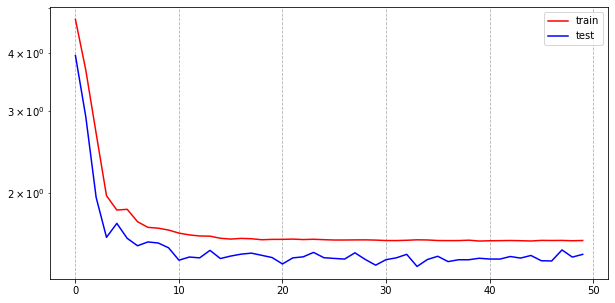

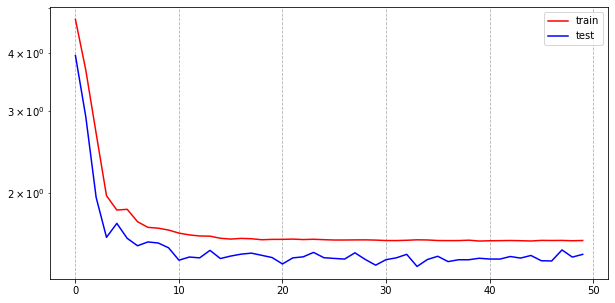

In [22]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 50
step_size = 100

fr, ch, y_sh = X_test_n.shape[1], X_test_n.shape[2], Y_test_n.shape[1]

ks1 = [fr,32,16,8,5]

model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,5], y_sh, indexing=True).to(device)
model = train(model, X_train, Y_train, X_test, Y_test, lr, step_size, batch_size, epochs, loss_fn, True);

torch.cuda.empty_cache()
X_train_lower = model.encode(X_train).cpu().detach().numpy()
X_test_lower = model.encode(X_test).cpu().detach().numpy()

RMSE_dict = {}

for rank1 in range(1,X_train_lower.shape[1]+1,1):   
    for rank2 in range(1,X_train_lower.shape[2]+1,1):
        for rank3 in range(1,X_train_lower.shape[3]+1,1):
                RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_hs_n, X_test_lower, Y_te_hs_n, [rank1,rank2,rank3], H_s[-1])


In [23]:
print('nRMSE =', RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

nRMSE = 1.0194886370315766


## With hankelization along both dim

In [4]:
data, H_b = tensorization(X_train_n, Y_train_n, X_test_n, Y_test_n, [[10,2],[10]], [[0,2],[0]])
X_tr_hb_n, Y_tr_hb_n, X_te_hb_n, Y_te_hb_n = data

print('X train:', X_tr_hb_n.shape)
print('Y train:', Y_tr_hb_n.shape)
print('X test:', X_te_hb_n.shape)
print('Y test:', Y_te_hb_n.shape)

X_test = torch.from_numpy(X_te_hb_n).float().to(device)
Y_test = torch.from_numpy(Y_te_hb_n).float().to(device)
X_train = torch.from_numpy(X_tr_hb_n).float().to(device) 
Y_train = torch.from_numpy(Y_tr_hb_n).float().to(device) 

X train: (1491, 10, 27, 31, 2)
Y train: (1491, 10, 3)
X test: (741, 10, 27, 31, 2)
Y test: (741, 10, 3)


### HOPLS

In [18]:
MSE_test = dict(np.load('experiments/ECoG32_hb_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,3,3,1), Km = (3,1), R = 20 nRMSE = 1.1403114292767995


### MPCA

In [12]:
U_x = scipy.io.loadmat('MPCA/32_X_hb.mat')['ans']
U_y = scipy.io.loadmat('MPCA/32_Y_hb.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [10, 1, 7, 2]
Y [8, 3]


In [19]:
MSE_test = dict(np.load('experiments/ECoG32_hb_hb_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (3, 1, 7, 2) nRMSE = 1.9446141851604182


### Autoencoder

In [3]:
MSE_test = dict(np.load('experiments/ECoG32_hb.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is 3,1,3,2 nRMSE = 1.115831844124811


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 50
step_size = 100

fr, ch, y_sh = X_test_n.shape[1], X_test_n.shape[2], Y_test_n.shape[1]

ks1 = [fr,32,16,8,1]
ks2 = [ch-1,16,8,3]

model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,2]], [10,3], y_sh*10, indexing=True).to(device)
model = train(model, X_train, Y_train, X_test, Y_test, lr, step_size, batch_size, epochs, loss_fn, False)

torch.cuda.empty_cache()
X_train_lower = model.encode(X_train).cpu().detach().numpy()
X_test_lower = model.encode(X_test).cpu().detach().numpy()

RMSE_dict = {}
print(f'{dataset_exp}, Finished training {N},{K1},{K2},{K3}')
for rank1 in range(1,X_train_lower.shape[1]+1,1):   
    for rank2 in range(1,X_train_lower.shape[2]+1,1):
        for rank3 in range(1,X_train_lower.shape[3]+1,1):
            for rank4 in range(1,X_train_lower.shape[4]+1,1):
                RMSE_dict[f'{rank1},{rank2},{rank3},{rank4}'] = tensor_regression(X_train_lower, Y_tr_hb_n, X_test_lower, Y_te_hb_n, [rank1,rank2,rank3,rank4], H_b[-1])

In [ ]:
print('nRMSE =', RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])